In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')
good = data[data['default'] == 0]
bad = data[data['default'] == 1]
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1

### 1) Построим нормализованные гистограммы двух групп

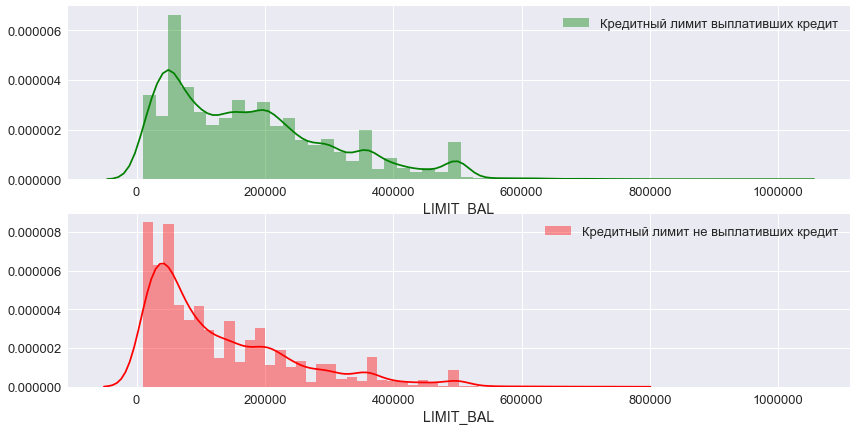

In [3]:
sns.set(font_scale=1.3)
plt.figure(figsize=(14, 7))

plt.subplot(211)
sns.distplot(good.LIMIT_BAL, color='g', label='Кредитный лимит выплативших кредит')
plt.legend()

plt.subplot(212, sharex=plt.subplot(211))
sns.distplot(bad.LIMIT_BAL, color='r', label='Кредитный лимит не выплативших кредит')
plt.legend()

### 2.1) Проверим гипотезу о равенстве медиан

Будем использовать scipy.stats.median_test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html)

* H0: медианы двух выборок равны
* H1: медианы как-то отличаются

In [4]:
from scipy.stats import median_test
stat, p_value, med, con_table = median_test(good.LIMIT_BAL, bad.LIMIT_BAL)
print('Достигаемый уровень значимости:', p_value)
print('Модуль разности медиан:', np.abs(good.LIMIT_BAL.median() - bad.LIMIT_BAL.median()))

Достигаемый уровень значимости: 1.34714180115e-150
Модуль разности медиан: 60000.0


Нулевая гипотеза уверенно отвергается, медианы отличаются примерно на 60000.

### 2.2) Интервально оценим медианы двух выборок, затем их разность.

Сделаем это с помощью бутстрепа

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

good_median_scores = list(map(np.median, get_bootstrap_samples(good.LIMIT_BAL.values, 1000)))
bad_median_scores = list(map(np.median, get_bootstrap_samples(bad.LIMIT_BAL.values, 1000)))

print ("95% доверительный интервал для медианы кредитного лимита выплативших кредит:",  stat_intervals(good_median_scores, 0.05))
print ("95% доверительный интервал для медианы кредитного лимита не выплативших кредит:",  stat_intervals(bad_median_scores, 0.05))

95% доверительный интервал для медианы кредитного лимита выплативших кредит: [ 150000.  150000.]
95% доверительный интервал для медианы кредитного лимита не выплативших кредит: [ 80000.  90000.]


#### Оценим интервально разность медиан

In [6]:
delta_median_scores = list(map(lambda x: np.abs(x[1] - x[0]), zip(good_median_scores, bad_median_scores)))
print ("95% доверительный интервал для разности медиан кредитного лимита",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для разности медиан кредитного лимита [ 60000.  70000.]


Интервалы не пересекаются, мы можем с уверенностью сказать, что медианы двух выборок отличаются.

### 3) Проверим гипотезу о равенстве распределений

U-критерий Манна-Уитни нам не подходит из-за большого кол-ва совпадающих значений в выборках . 

(https://ru.wikipedia.org/wiki/U-критерий_Манна_—_Уитни)

In [7]:
print('Кол-во значений, которые в этих выборках одинаковы:', sum([1 for item in good['LIMIT_BAL'] if item in bad['LIMIT_BAL']]))


Кол-во значений, которые в этих выборках одинаковы: 1280


#### Будем использовать перестановочный критерий для независимых выборок.

* H0: выборки из одного и того же распределения
* H1: распределение одной из выборок сдвинуто на $\Delta$

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, list(range(n)))) \
                    for index in itertools.combinations(list(range(n)), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

Изобразим нулевое распределение статистики. Видим, что оно похоже на нормальное. Также есть отбивающиеся от общих значения в левом и правом хвосте.

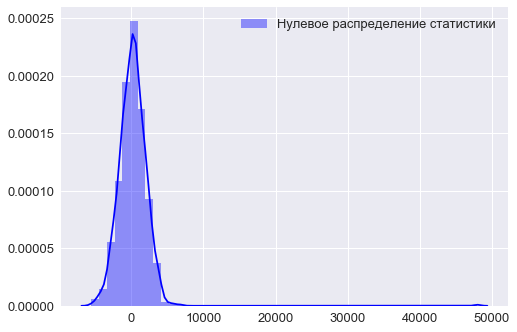

In [9]:
sns.distplot(permutation_zero_dist_ind(good.LIMIT_BAL, bad.LIMIT_BAL, max_combinations=1000), color='b', norm_hist=True, label='Нулевое распределение статистики')
plt.legend()

In [10]:
stat = permutation_t_stat_ind(good.LIMIT_BAL, bad.LIMIT_BAL)
p_value_1 = permutation_test(good.LIMIT_BAL, bad.LIMIT_BAL, max_permutations=10000)
print('Значение статистики:', stat)
print('Достигаемый уровень значимости при max_permutations=10000:', p_value_1)

Значение статистики: 47990.069654772495
Достигаемый уровень значимости при max_permutations=10000: 0.0001


Нулевая гипотеза уверенно отвергается, распределение одной из выборок имеет сдвиг $\Delta$, относительно другой.

## Задание 2

### 1) Построим гистограммы двух групп

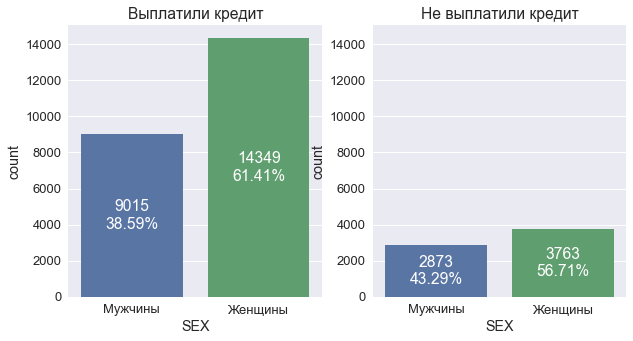

In [11]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
sns.countplot(x='SEX', data=good)
ax1.set_xticklabels(['Мужчины', 'Женщины'])
ax1.set_title("Выплатили кредит")

ax2 = plt.subplot(122, sharey=ax1)
sns.countplot(x='SEX', data=bad)
ax2.set_xticklabels(['Мужчины', 'Женщины'])
ax2.set_title("Не выплатили кредит")

for ax in [ax1, ax2]:
    if ax == ax1:
        total = len(good.SEX)
    elif ax == ax2:
        total = len(bad.SEX)
    for p in ax.patches:
        height = p.get_height()
        percent = height*100 / total
        ax.text(p.get_x()+p.get_width()/2, height/2, '{:1.0f}\n{:1.2f}%'.format(height, percent), va="center", ha="center", color='w')

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

У нас две __независимые__ бинарные выборки. 
### 2.1) Построим интервальную оценку разности долей мужчин в этих выборках и всопользуемся Z-критерием для разности долей.

Для этого нам необходимо будет создать таблицу сопряженности и воспользоваться формулами ниже.

* X1 - первая выборка
* X2 - вторая выборка
* 1 - мужчины
* 0 - женщины

| $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$


In [12]:
# Функции, реализующие эту интервальную оценку + проверку гипотезы против заданной альтернативы

from scipy.stats import norm

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2)
    
    p1 = sum(sample1) / len(sample1)
    p2 = sum(sample2) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = sum(sample1) / n1
    p2 = sum(sample2) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)

# Меняем в выборках значения, соответсвующие женщинам (с 2 на 0)
print ("95% доверительный интервал разности долей мужчин:", \
       proportions_diff_confint_ind(good.SEX.replace(2,0), bad.SEX.replace(2,0)))

95% доверительный интервал разности долей мужчин: (-0.060548077974896725, -0.033634932749628671)


Доверительный интервал не содержит нуля, скорей всего гендерный состав в двух группах отличается.
Найдем статистику $Z$ и рассчитаем по ней p_value, чтобы проверить нулевую гипотезу против двухсторонней альтернативы.
* H0: Доли мужчин в выборках не отличаются
* H1: Гендерный состав как-то отличается

In [13]:
print ("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(good.SEX.replace(2,0), bad.SEX.replace(2,0))))

p-value: 4.47286652161e-12


Нулевая гипотеза уверенно отвергается, гендерный состав в двух группах клиентов отличается.

## Задание 3

### 3.1) Построим гистограммы двух групп по признаку образование.

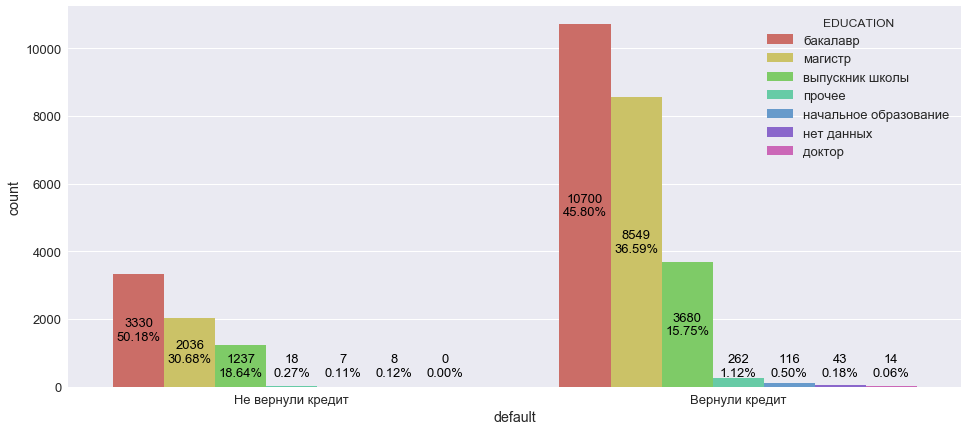

In [14]:
num2edu =  {0:'доктор', 1:'магистр', 2:'бакалавр', 3:'выпускник школы', 4:'начальное образование', 5:'прочее', 6:'нет данных'}
data.EDUCATION = data.EDUCATION.replace(num2edu)

num2def =  {0: 'Вернули кредит', 1: 'Не вернули кредит'}
data.default = data.default.replace(num2def)

plt.figure(figsize=(16, 7))
ax = sns.countplot(x='default', data=data, hue='EDUCATION', palette='hls')
patch_count = 1
for p in ax.patches:
        if patch_count % 2 == 1:
            total = sum(data.default == data.default.unique()[0])
        else:
            total = sum(data.default == data.default.unique()[1])
        height = p.get_height()
        h_plot = height
        if np.isnan(height) == False:
            if height < 1000:
                h_plot = 1200
        else:
            height = 0
            h_plot = 1200

        percent = height*100 / total
        ax.text(p.get_x()+p.get_width()/2, h_plot/2, '{:1.0f}\n{:1.2f}%'.format(height, percent), va="center", ha="center", color='black', fontsize=13)
        patch_count += 1

### 3.2) Составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым и ожидаемым количеством человек. 
* Наблюдаемое кол-во - это наблюдаемые в выборке частоты
* Ожидаемое кол-во - это частоты при условии, что люди с тем или иным образованием в группах плательщиков/не плательщиков распределены равномерно.

In [15]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,бакалавр,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,Не вернули кредит
1,2,120000,2,бакалавр,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Не вернули кредит
2,3,90000,2,бакалавр,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,Вернули кредит
3,4,50000,2,бакалавр,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,Вернули кредит
4,5,50000,1,бакалавр,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,Вернули кредит


In [16]:
from scipy.stats.contingency import expected_freq


EDUCATION_list = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']

observed = [((data[data.EDUCATION == item].default == 'Вернули кредит').sum(), (data[data.EDUCATION == item].default == 'Не вернули кредит').sum()) for item in EDUCATION_list]
exp_freq = np.round(expected_freq(observed=observed))

res_table = pd.DataFrame(np.hstack([observed, exp_freq, observed - exp_freq]),\
            columns=['Выплатили (набл.)', 'Не выплатили (набл.)', 'Выплатили (ожид.)',\
                     'Не выплатили (ожид.)', 'Выплатили (разница)', 'Не выплатили (разница)'])                       
res_table['Выплатили (Доля разности %)'] = np.round(res_table['Выплатили (разница)']*100 / (res_table['Выплатили (набл.)'] + res_table['Не выплатили (набл.)']), 2)

res_table.insert(loc=0, column='Образование', value=EDUCATION_list)
res_table.style.applymap(lambda x: 'color: blue', subset=['Выплатили (разница)', 'Выплатили (Доля разности %)'])

,Образование,Выплатили (набл.),Не выплатили (набл.),Выплатили (ожид.),Не выплатили (ожид.),Выплатили (разница),Не выплатили (разница),Выплатили (Доля разности %)
0,доктор,14,0,11,3,3,-3,21.43
1,магистр,8549,2036,8244,2341,305,-305,2.88
2,бакалавр,10700,3330,10927,3103,-227,227,-1.62
3,выпускник школы,3680,1237,3829,1088,-149,149,-3.03
4,начальное образование,116,7,96,27,20,-20,16.26
5,прочее,262,18,218,62,44,-44,15.71
6,нет данных,43,8,40,11,3,-3,5.88


### 3.3) Визуализируем долю разности

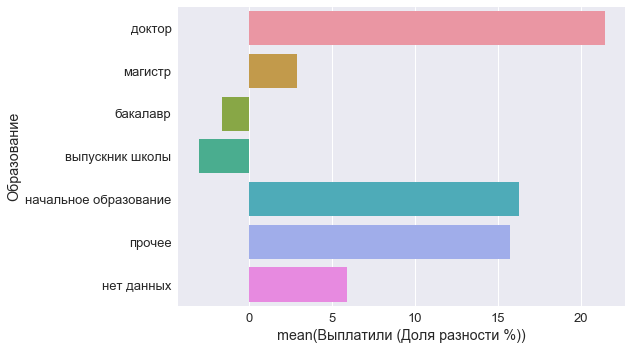

In [17]:
sns.barplot(x='Выплатили (Доля разности %)', y='Образование', data=res_table)

### 3.4) Проверим гипотезу о том, что уровень образования не влияет на кол-во выплаченных кредитов.
Будем использовать метод scipy.stats.chi2_contingency (https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html)
* H0: Уровень образования не влияет на параметр default (плательщики/неплательщики равномерно распределены по категориям образования)
* H1: Есть какое-то влияние образования.

In [18]:
from scipy.stats import chi2_contingency
stat, p_value, dof, expected = chi2_contingency(observed=res_table[['Выплатили (набл.)', 'Не выплатили (набл.)']], correction=True)
print('Статистика:', stat)
print('P_value:', p_value)

Статистика: 163.21655787
P_value: 1.23326262454e-32


Нулевая гипотеза уверенно отвергается, параметр образование имеет влияние на параметр default

### 3.5) Выводы
С помощью expected_freq мы получили ожидаемые частоты, при которых плательщики и неплательщики распределены равномерно по группе "Образование". Затем мы вычислили разность между наблюдаемыми и ожидаемыми частотами, а также посчитали долю этой разности от общего кол-ва человек в этой группе.

Чем больше процент доли разности, тем сильнее принадлежность к этой группе влияет на то, что __кредит будет возвращен__.

Отсюда:
* Принадлежность к категории '__выпускник школы__' является наилучшим индикатором того, что человек кредит __не выплатит__.
* Принадлежность к категории '__доктор__' является наилучшим индикатором того, что человек кредит __выплатит__.

## Задание 4

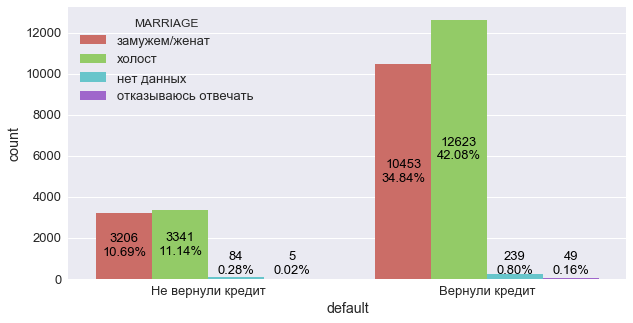

In [19]:
num2mar =  {0:'отказываюсь отвечать', 1:'замужем/женат', 2:'холост', 3:'нет данных'}
data.MARRIAGE = data.MARRIAGE.replace(num2mar)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='default', data=data, hue='MARRIAGE', palette='hls')
total = len(data)
for p in ax.patches:
        height = p.get_height()
        h_plot = height
        if np.isnan(height) == False:
            if height < 1000:
                h_plot = 1500
        else:
            height = 0
            h_plot = 1500
        percent = height*100 / total
        ax.text(p.get_x()+p.get_width()/2, h_plot/2, '{:1.0f}\n{:1.2f}%'.format(height, percent), va="center", ha="center", color='black', fontsize=13)

У нас здесь категориальные переменные, поэтому нужно вычислить коэффициент V Крамера. 

Насколько я понимаю, 
* нужно составить таблицу сопряженности,
* вычислить для категориальных признаков статистику хи квадрат
* воспользоваться формулой <img src="2.png">

(Информация взята из этого конспекта лекций https://www.coursera.org/learn/stats-for-data-analysis/supplement/ZxHyU/konspiekt)

__Построим таблицу сопряженности__

In [20]:
X1 = ['Не вернули кредит', 'Вернули кредит']
X2 = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']
a1 = np.array([np.sum((data.default == item1) & (data.MARRIAGE == item)) for item1 in X1 for item in X2]).reshape(2, 4)
df = pd.DataFrame(a1, columns=X2)
df.insert(loc=0, column='default', value=X1)
df

,default,отказываюсь отвечать,замужем/женат,холост,нет данных
0,Не вернули кредит,5,3206,3341,84
1,Вернули кредит,49,10453,12623,239


In [21]:
stat_chi2, p_value, dof, ex = chi2_contingency(observed=df[X2])
print('Статистика хи квадрат:', stat_chi2)

Статистика хи квадрат: 35.6623958343


In [22]:
koef_kramer = np.sqrt(stat_chi2 / (len(data) * (2 - 1)))
print('koef_kramer:', koef_kramer)

koef_kramer: 0.0344782036628


Коэффициент корреляции между категориальными признаками __MARRIAGE__ и __default__ равен примерно __0.035__

__Я в этом задании ой как не уверен, поэтому молюсь на хороший фидбэк_plz)__

## Задание 5

 ### 5.1) Построим нормированные гистограммы возраста в группах

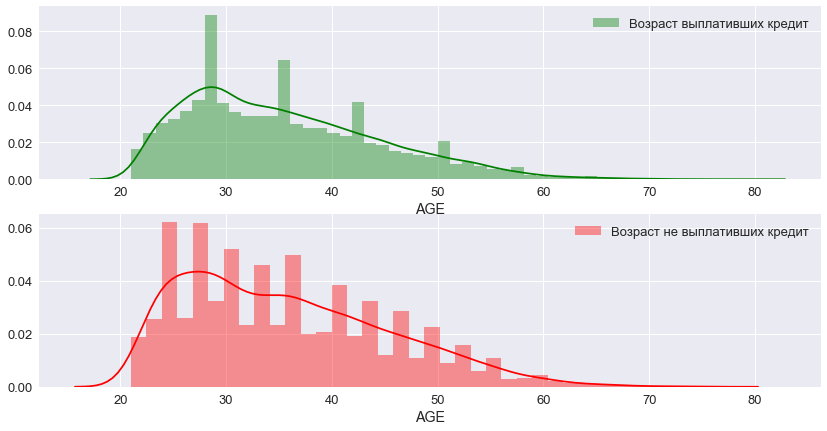

In [23]:
sns.set(font_scale=1.3)
plt.figure(figsize=(14, 7))

plt.subplot(211)
sns.distplot(good.AGE, color='g', label='Возраст выплативших кредит')
plt.legend()

plt.subplot(212, sharex=plt.subplot(211))
sns.distplot(bad.AGE, color='r', label='Возраст не выплативших кредит')
plt.legend()

### 5.2) Проверим гипотезу равенстве медианных значений возрастов людей
Будем использовать scipy.stats.median_test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html)

* H0: медианы двух выборок равны
* H1: медианы как-то отличаются

In [24]:
from scipy.stats import median_test
stat, p_value, med, con_table = median_test(good.AGE, bad.AGE)
print('Статистика:', stat)
print('Достигаемый уровень значимости:', p_value)
print('Модуль разности медиан:', np.abs(good.AGE.median() - bad.AGE.median()))

Статистика: 7.82723806464
Достигаемый уровень значимости: 0.00514646808123
Модуль разности медиан: 0.0


Нулевая гипотеза не отвергается на уровне значимости 0.05, в то время как медианы двух выборок равны.

### 5.3) Интервально оценим медианы двух выборок, затем их разность.

Сделаем это с помощью бутстрепа

In [25]:
good_median_scores = list(map(np.median, get_bootstrap_samples(good.AGE.values, 1000)))
bad_median_scores = list(map(np.median, get_bootstrap_samples(bad.AGE.values, 1000)))

print ("95% доверительный интервал для медианы кредитного лимита выплативших кредит:",  stat_intervals(good_median_scores, 0.05))
print ("95% доверительный интервал для медианы кредитного лимита не выплативших кредит:",  stat_intervals(bad_median_scores, 0.05))

delta_median_scores = list(map(lambda x: np.abs(x[1] - x[0]), zip(good_median_scores, bad_median_scores)))
print ("95% доверительный интервал для разности медиан кредитного лимита",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для медианы кредитного лимита выплативших кредит: [ 34.  34.]
95% доверительный интервал для медианы кредитного лимита не выплативших кредит: [ 34.  35.]
95% доверительный интервал для разности медиан кредитного лимита [ 0.  1.]


### 5.4) Проверим гипотезу о равенстве распределений с помощью перестановочного критерия 

* H0: выборки из одного и того же распределения
* H1: распределение одной из выборок сдвинуто на $\Delta$

Изобразим нулевое распределение статистики. Видим, что оно похоже на нормальное.

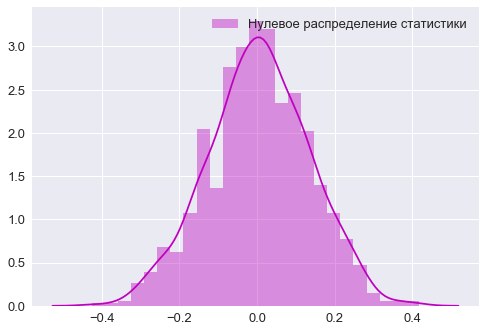

In [26]:
sns.distplot(permutation_zero_dist_ind(good.AGE, bad.AGE, max_combinations=1000), color='m', label='Нулевое распределение статистики')
plt.legend()

In [27]:
stat = permutation_t_stat_ind(good.AGE, bad.AGE)
p_value_1 = permutation_test(good.AGE, bad.AGE, max_permutations=10000)
print('Значение статистики:', stat)
print('Достигаемый уровень значимости при max_permutations=10000:', p_value_1)

Значение статистики: -0.308472517494188
Достигаемый уровень значимости при max_permutations=10000: 0.0142


Нулевая гипотеза на уровне значимости 0.05 отвергается. 

Проверка гипотез по возрасту в группах выявила, что наборы данных отличаются статистически значимо.
Но практической значимости здесь нет. Максимум, что мы поняли - так это то, что медианы двух групп могут отличаться на 1 (единицу). __Вряд ли__ эта разница значимо влияет на параметр default.